In [3]:
%pip install scikit-learn
%pip install lightgbm
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Loading engineered features...

Initializing model development...

Creating validation splits...

Training model...

Fold 1:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	training's rmse: 0.713267	valid_1's rmse: 0.838738
Validation R²: 0.0139

Plotting analysis...


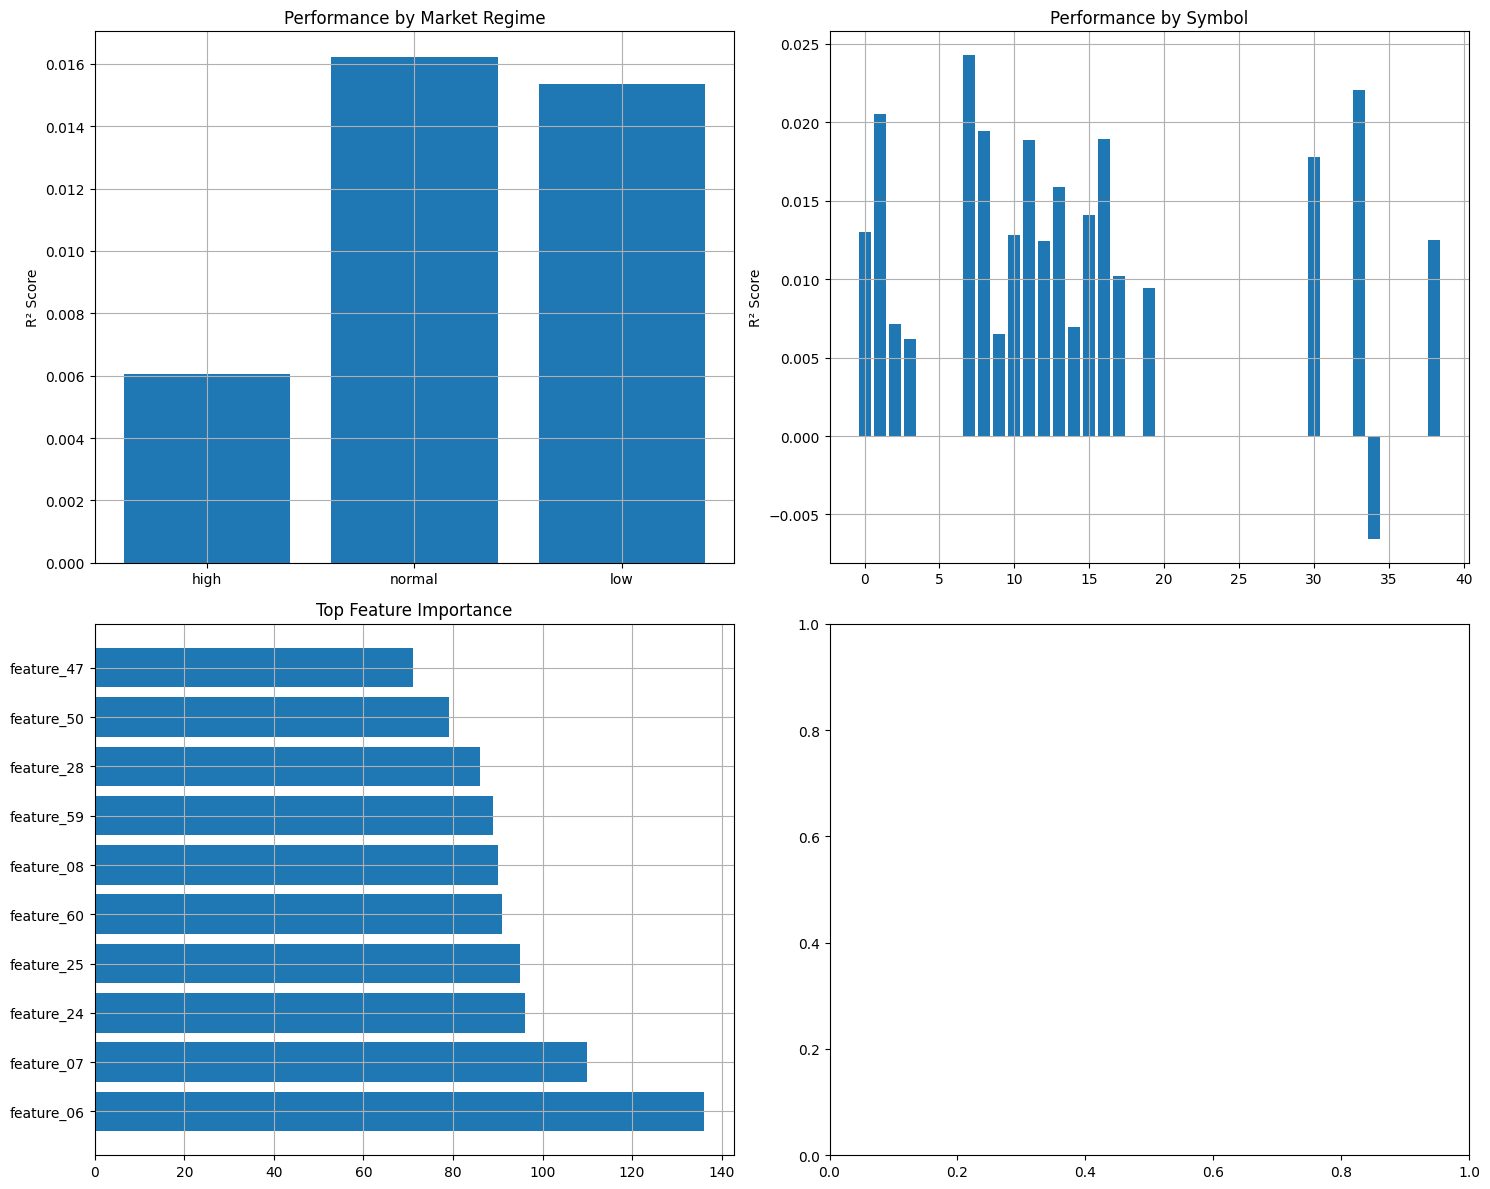


Fold 2:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	training's rmse: 0.774709	valid_1's rmse: 0.920274
Validation R²: 0.0130

Plotting analysis...


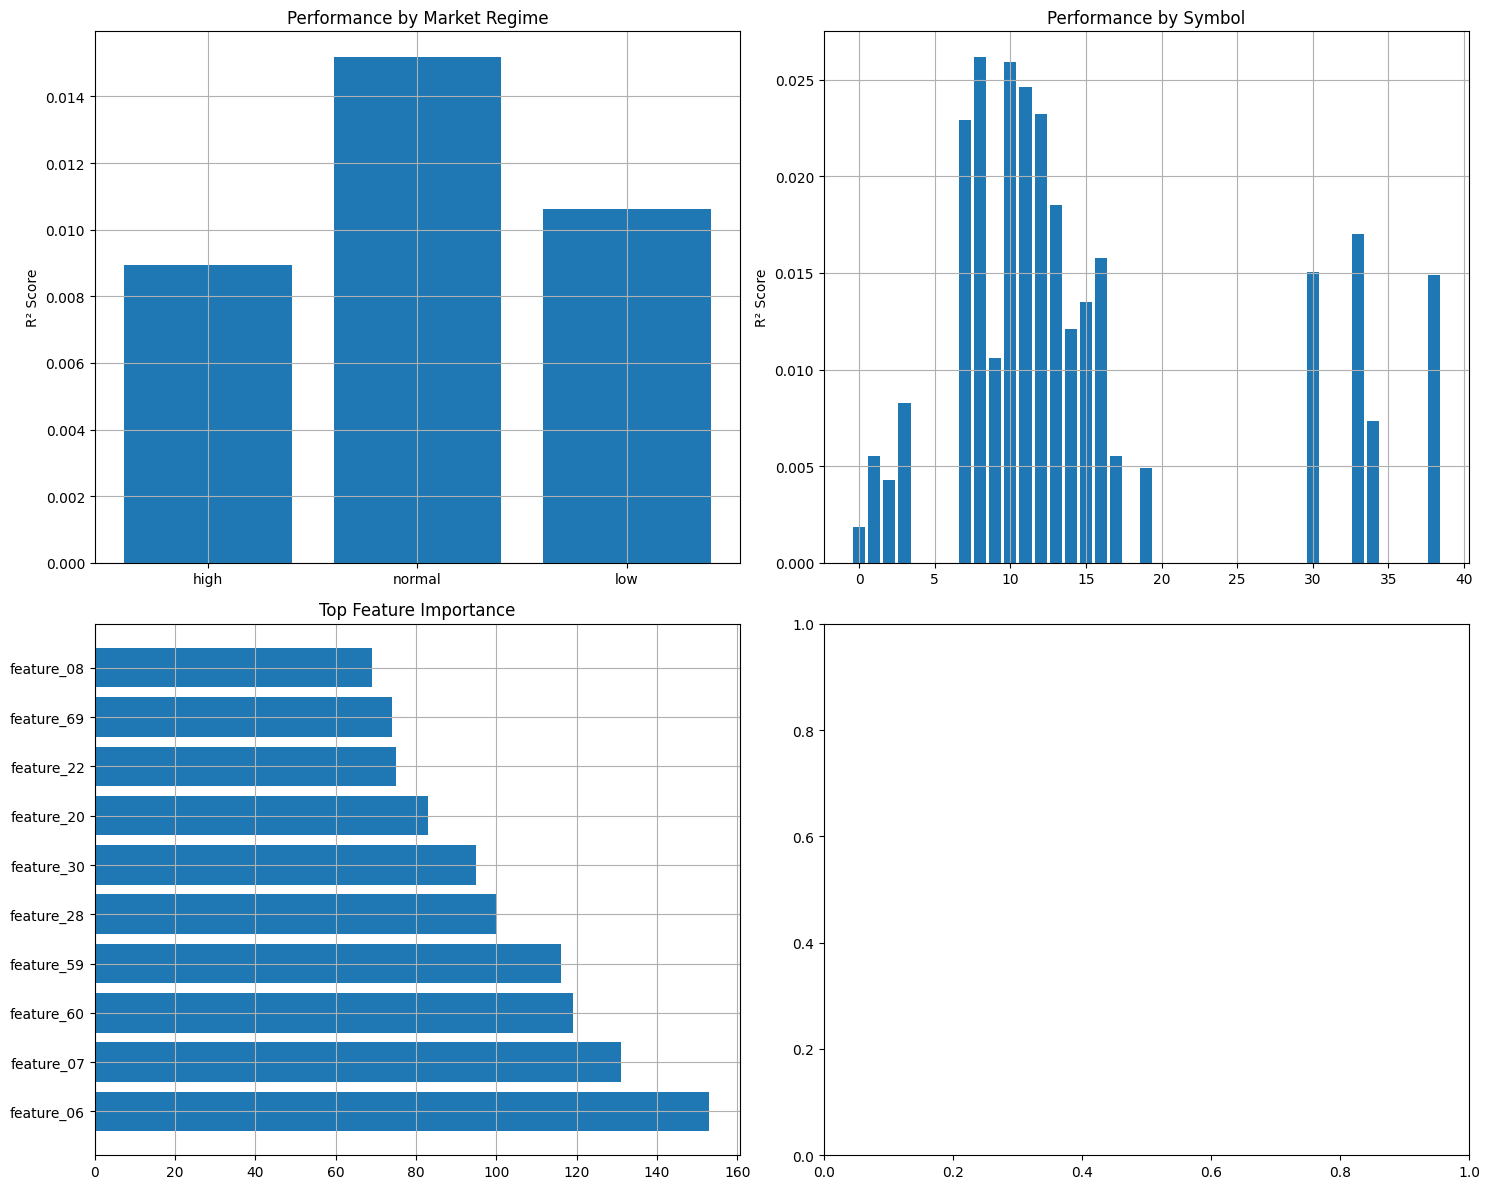


Fold 3:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	training's rmse: 0.817542	valid_1's rmse: 0.860974
Validation R²: 0.0105

Plotting analysis...


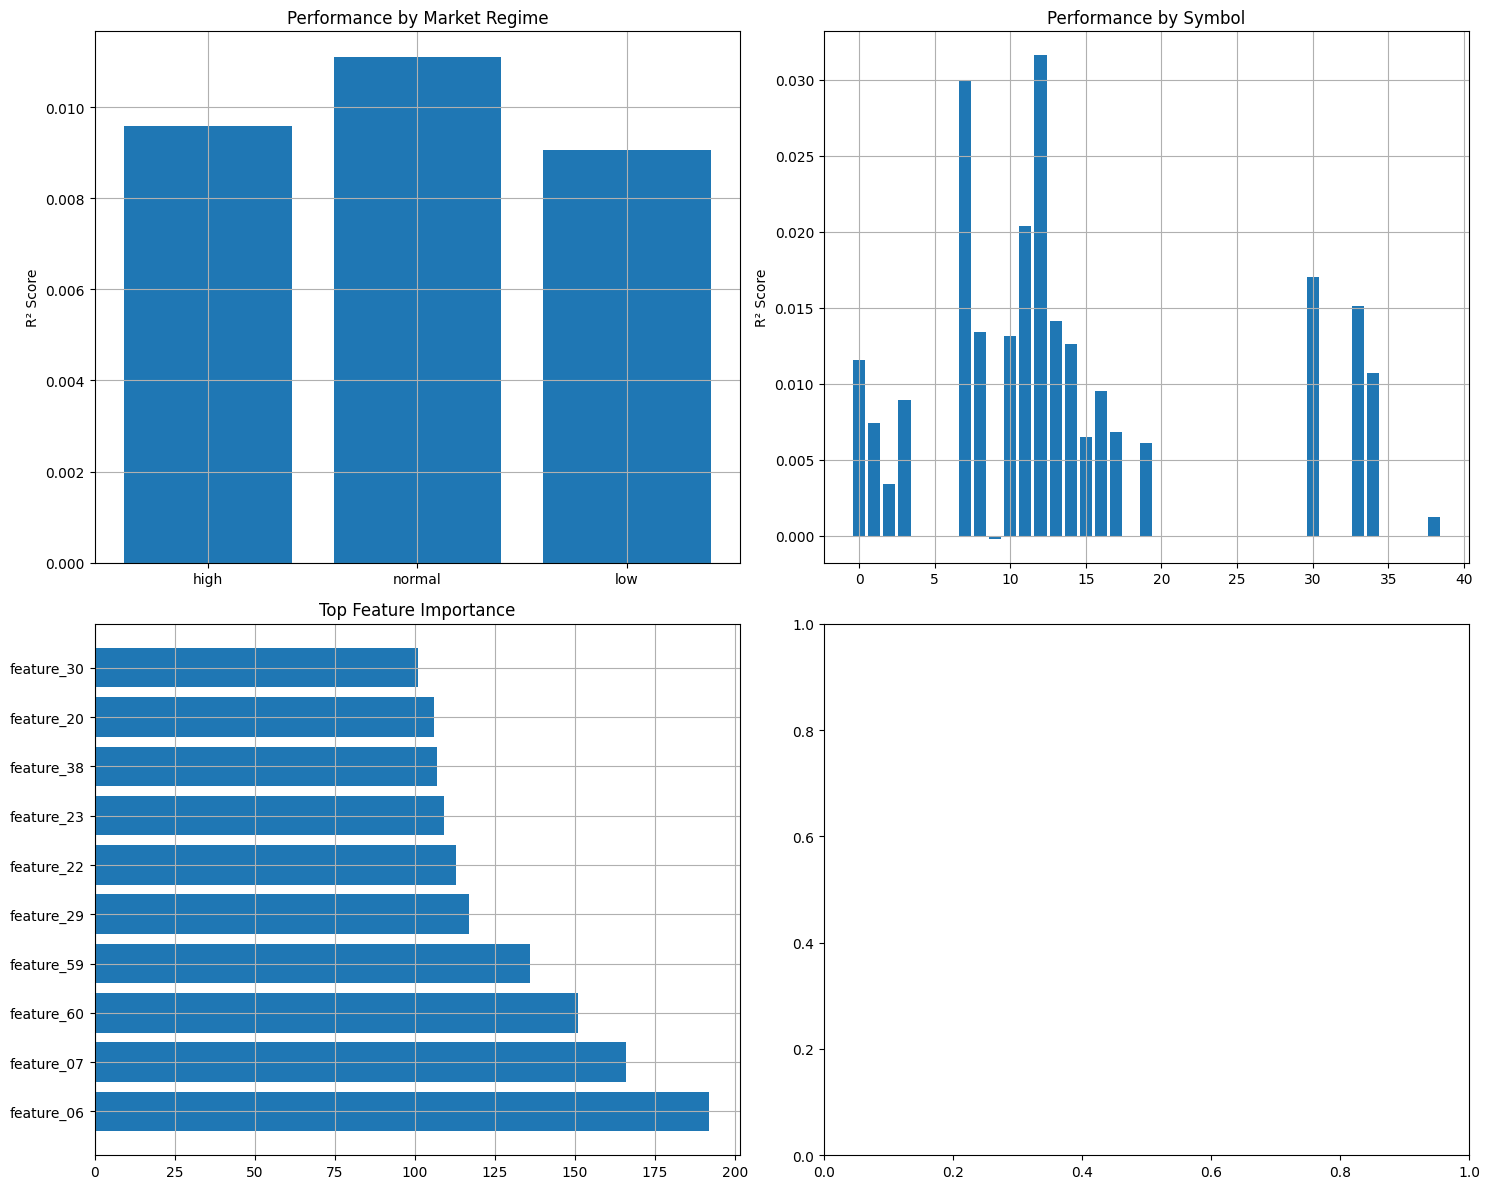


Fold 4:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[193]	training's rmse: 0.822986	valid_1's rmse: 0.755168
Validation R²: 0.0157

Plotting analysis...


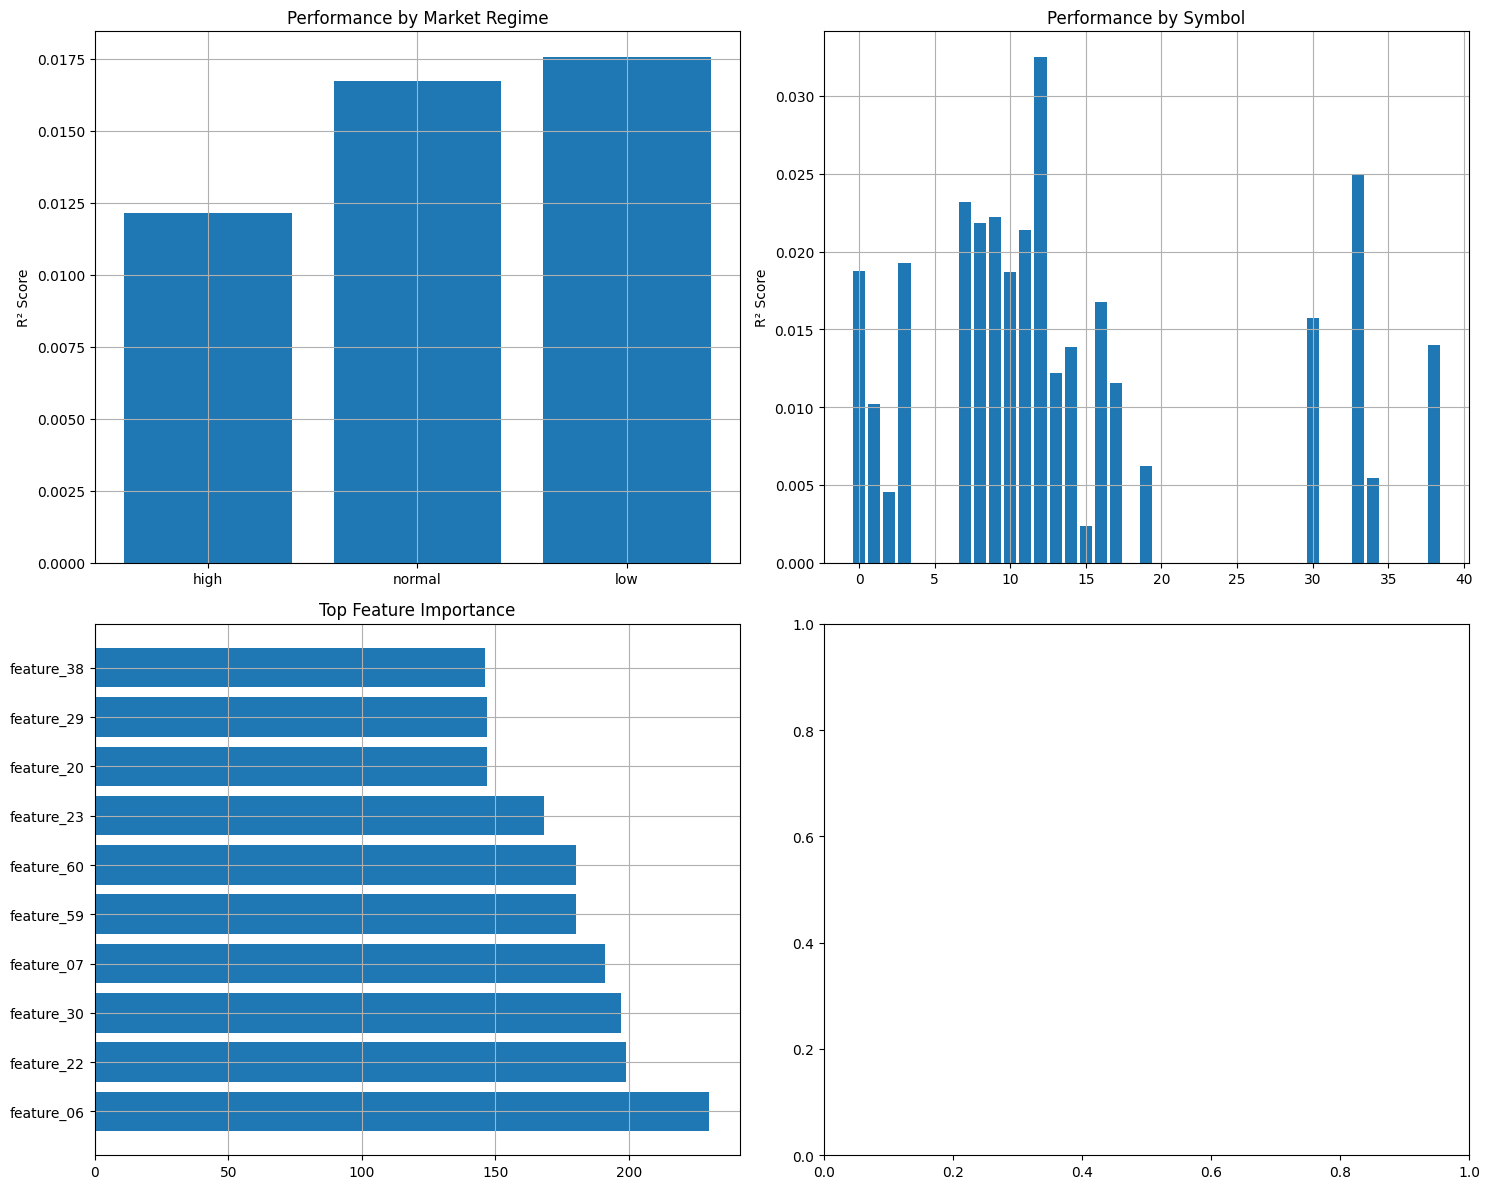


Fold 5:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[143]	training's rmse: 0.812822	valid_1's rmse: 0.949698
Validation R²: 0.0117

Plotting analysis...


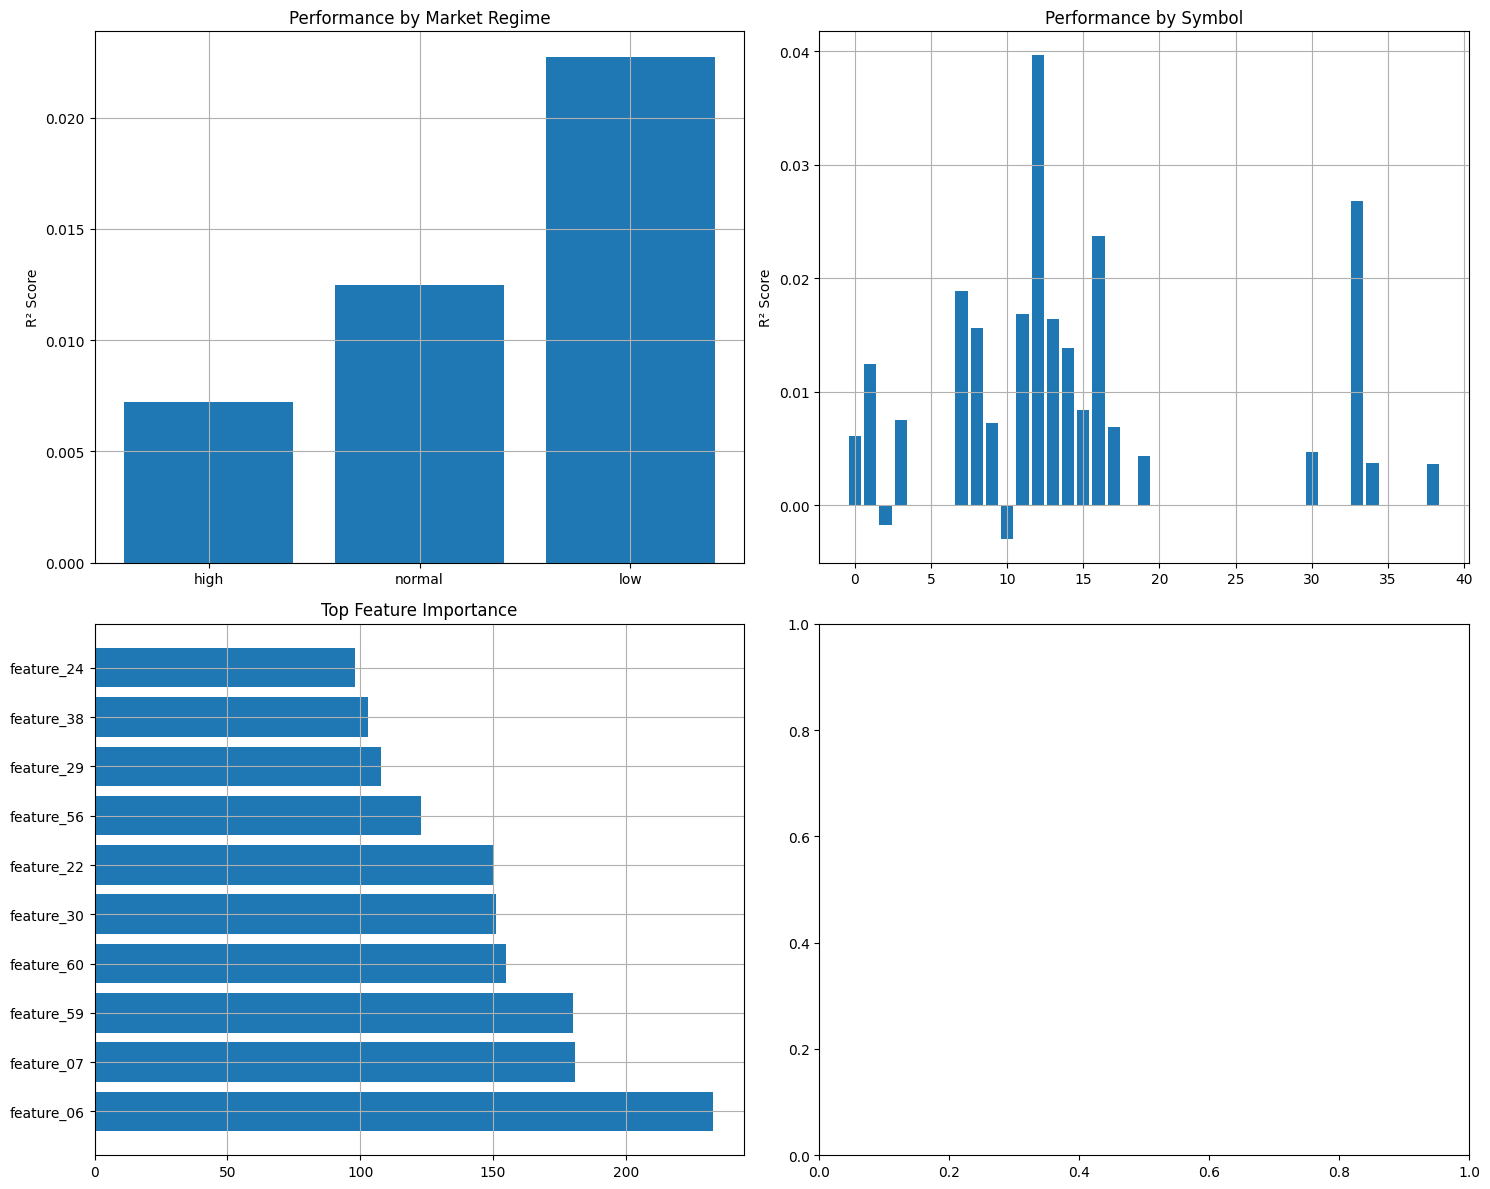


=== Model Development Summary ===
Average R² score: 0.0129 ± 0.0018

Best model from fold 4
Score: 0.0157

Top features:
feature_06: 230
feature_22: 199
feature_30: 197
feature_07: 191
feature_59: 180
feature_60: 180
feature_23: 168
feature_20: 147
feature_29: 147
feature_38: 146


In [6]:
import polars as pl
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from sklearn.model_selection import TimeSeriesSplit

class ModelDevelopment:
    """
    Model development pipeline for market prediction
    """
    def __init__(self, df: pl.DataFrame):
        self.df = df
        self.feature_cols = [col for col in df.columns 
                           if col.startswith(('feature_', 'target_lag_', 
                                            'return_', 'symbol_'))]
        self.target_col = 'responder_6'
        
    def calculate_regime(self, df: pl.DataFrame) -> pl.DataFrame:
        """
        Calculate volatility regime dynamically
        """
        # Calculate daily volatility
        daily_stats = (df.group_by('date_id')
                        .agg([
                            pl.col(self.target_col).std().alias('daily_vol')
                        ]))
        
        vol_mean = float(daily_stats['daily_vol'].mean())
        vol_std = float(daily_stats['daily_vol'].std())
        
        # Add regime classification
        daily_stats = daily_stats.with_columns([
            pl.when(pl.col('daily_vol') > vol_mean + vol_std)
              .then(pl.lit('high'))
              .when(pl.col('daily_vol') < vol_mean - vol_std)
              .then(pl.lit('low'))
              .otherwise(pl.lit('normal'))
              .alias('vol_regime')
        ])
        
        # Join back to original data
        return df.join(daily_stats.select(['date_id', 'vol_regime']), on='date_id')
    
    def prepare_validation_splits(self, n_splits: int = 5) -> List[Tuple]:
        """
        Create time-based validation splits
        """
        # Sort by time
        df_sorted = self.df.sort(['date_id', 'time_id'])
        
        # Create splits
        tscv = TimeSeriesSplit(n_splits=n_splits)
        splits = []
        
        for train_idx, val_idx in tscv.split(df_sorted):
            train_data = df_sorted[train_idx]
            val_data = df_sorted[val_idx]
            
            # Calculate regimes for each split
            train_data = self.calculate_regime(train_data)
            val_data = self.calculate_regime(val_data)
            
            splits.append((train_data, val_data))
            
        return splits
    
    def train_base_model(self, train_data: pl.DataFrame, 
                        val_data: pl.DataFrame) -> Dict:
        """
        Train LightGBM model with validation
        """
        # Prepare data
        X_train = train_data.select(self.feature_cols).to_numpy()
        y_train = train_data[self.target_col].to_numpy()
        w_train = train_data['weight'].to_numpy()
        
        X_val = val_data.select(self.feature_cols).to_numpy()
        y_val = val_data[self.target_col].to_numpy()
        w_val = val_data['weight'].to_numpy()
        
        # Create dataset
        train_set = lgb.Dataset(X_train, y_train, weight=w_train, 
                              feature_name=self.feature_cols)
        val_set = lgb.Dataset(X_val, y_val, weight=w_val, 
                            feature_name=self.feature_cols)
        
        # Model parameters
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1
        }
        
        # Train model
        model = lgb.train(
            params,
            train_set,
            num_boost_round=1000,
            valid_sets=[train_set, val_set],
            callbacks=[lgb.early_stopping(50)]
        )
        
        # Make predictions
        val_pred = model.predict(X_val)
        
        # Calculate weighted R2
        weighted_r2 = self.calculate_weighted_r2(y_val, val_pred, w_val)
        
        return {
            'model': model,
            'validation_score': weighted_r2,
            'feature_importance': dict(zip(self.feature_cols, 
                                        model.feature_importance()))
        }
    
    def calculate_weighted_r2(self, y_true: np.ndarray, 
                            y_pred: np.ndarray, 
                            weights: np.ndarray) -> float:
        """
        Calculate weighted R² score
        """
        numerator = np.sum(weights * (y_true - y_pred) ** 2)
        denominator = np.sum(weights * y_true ** 2)
        r2 = 1 - numerator / denominator
        return r2
    
    def analyze_predictions(self, model_dict: Dict, 
                          val_data: pl.DataFrame) -> Dict:
        """
        Analyze model predictions
        """
        # Make predictions
        X_val = val_data.select(self.feature_cols).to_numpy()
        y_val = val_data[self.target_col].to_numpy()
        val_pred = model_dict['model'].predict(X_val)
        
        # Analysis by market regime
        regimes = val_data['vol_regime'].to_numpy()
        regime_scores = {}
        
        for regime in ['high', 'normal', 'low']:
            mask = regimes == regime
            if mask.any():
                regime_scores[regime] = self.calculate_weighted_r2(
                    y_val[mask], 
                    val_pred[mask], 
                    val_data['weight'].to_numpy()[mask]
                )
        
        # Analysis by symbol
        symbols = val_data['symbol_id'].to_numpy()
        symbol_scores = {}
        
        for symbol in np.unique(symbols):
            mask = symbols == symbol
            symbol_scores[symbol] = self.calculate_weighted_r2(
                y_val[mask], 
                val_pred[mask], 
                val_data['weight'].to_numpy()[mask]
            )
        
        return {
            'regime_performance': regime_scores,
            'symbol_performance': symbol_scores,
            'overall_score': model_dict['validation_score'],
            'top_features': sorted(
                model_dict['feature_importance'].items(),
                key=lambda x: x[1],
                reverse=True
            )[:10]
        }
    
    def plot_analysis(self, analysis_dict: Dict):
        """
        Plot model analysis results
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot regime performance
        regime_scores = analysis_dict['regime_performance']
        axes[0,0].bar(regime_scores.keys(), regime_scores.values())
        axes[0,0].set_title('Performance by Market Regime')
        axes[0,0].set_ylabel('R² Score')
        axes[0,0].grid(True)
        
        # Plot symbol performance
        symbol_scores = analysis_dict['symbol_performance']
        axes[0,1].bar(symbol_scores.keys(), symbol_scores.values())
        axes[0,1].set_title('Performance by Symbol')
        axes[0,1].set_ylabel('R² Score')
        axes[0,1].grid(True)
        
        # Plot top features
        top_features = analysis_dict['top_features']
        features, importances = zip(*top_features)
        axes[1,0].barh(range(len(features)), importances)
        axes[1,0].set_yticks(range(len(features)))
        axes[1,0].set_yticklabels(features)
        axes[1,0].set_title('Top Feature Importance')
        axes[1,0].grid(True)
        
        plt.tight_layout()
        plt.show()

# Run the analysis
print("Loading engineered features...")
df = pl.read_parquet("../data/processed/engineered_features.parquet")

print("\nInitializing model development...")
model_dev = ModelDevelopment(df)

print("\nCreating validation splits...")
splits = model_dev.prepare_validation_splits()

print("\nTraining model...")
results = []
for i, (train_data, val_data) in enumerate(splits):
    print(f"\nFold {i+1}:")
    model_dict = model_dev.train_base_model(train_data, val_data)
    analysis = model_dev.analyze_predictions(model_dict, val_data)
    results.append(analysis)
    print(f"Validation R²: {analysis['overall_score']:.4f}")
    
    print("\nPlotting analysis...")
    model_dev.plot_analysis(analysis)

print("\n=== Model Development Summary ===")
avg_score = np.mean([r['overall_score'] for r in results])
std_score = np.std([r['overall_score'] for r in results])
print(f"Average R² score: {avg_score:.4f} ± {std_score:.4f}")

print(f"\nBest model from fold {np.argmax([r['overall_score'] for r in results])+1}")
best_result = results[np.argmax([r['overall_score'] for r in results])]
print(f"Score: {best_result['overall_score']:.4f}")
print("\nTop features:")
for feature, importance in best_result['top_features']:
    print(f"{feature}: {importance}")